# SDS 271 Final Project Prototype
Group 1 Christy Yang, Vicky Xu, Xinran Bi, Yuzhang Fu
### Intro

The prototype comprises essential functions intended for data manipulation and visualization. We conducted tests using the 'safelySanitication' file, creating plots that depict the population using safely managed sanitation services (%) for 'Total' at Period 2017. We investigated China's population using safely managed sanitation services over time, categorized by 'Total,' 'Urban,' and 'Rural.' Additionally, the create_heatmap function generates a choropleth map visualizing this value of 2017 worldwide.

In [14]:
import pandas as pd
import geopandas as gpd
from ipyleaflet import Map, Choropleth, GeoData, LayersControl
import json
import branca.colormap
from ipywidgets import widgets
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

In [15]:
def load_data(file_path):
    """loads data from the given file path"""
    data = pd.read_csv(file_path)
    return data

def check_same_entries_in_Indicator(data):
    """checks whether all entries in the 'Indicator' column are identical"""
    return data['Indicator'].nunique() == 1

def plot_first_tooltip_by_location(data, period, column_name = None, location=None):
    """
    Plot the value of "First Tooltip" for Dim1 = 'Total' at a designated period for different locations.
    In particular, if column_name is not provided and all entries in the 'Indicator' column are identical, it uses the first entry in the 'Indicator' column as the column name. If the 'Dim1' column includes categories 'Urban', 'Total', and 'Rural', the function proceeds with plotting; otherwise, it notifies that the 'Dim1' column does not meet the specified criteria.
    """
    if column_name is None and check_same_entries_in_Indicator(data):
        column_name = data['Indicator'].iloc[0]
        
    # Filter data for the specified period and Dim1 = 'Total'
    filtered_data = data[(data['Period'] == period) & (data['Dim1'] == 'Total')]
    # Filter data based on the specified location(s)
    if location is not None:
        if isinstance(location, str):
            location = [location]
        filtered_data = filtered_data[filtered_data['Location'].isin(location)]

    if 'Dim1' in data.columns and set(data['Dim1'].unique()) == {'Urban', 'Total', 'Rural'}:
        # Plotting
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Location', y='First Tooltip', data=filtered_data)
        plt.title(f'{column_name}for Dim1 = Total at Period {period}')
        plt.xlabel('Location', fontsize=14)
        plt.ylabel(f'{column_name}', fontsize=14)
        plt.legend(title='Indicator', bbox_to_anchor=(1, 1), fontsize=14)
        plt.show()
    else:
        print("Dim1 column does not meet the specified criteria.")

There're three functions offer different visualizations within the given dataframe. `lineplot` generates a line plot displaying the trend of the "First Tooltip'' over time for a designated location. `scatterplot` creates a scatter plot demonstrating the relationship between 'Period' and 'First Tooltip' for a specific location. Finally, `barplot` generates a bar plot illustrating the distribution of 'First Tooltip' values across various time periods ('Period') for a specified location within the dataframe. 

In [16]:
# lineplot
def lineplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_location, x='Period', y='First Tooltip', hue = "Dim1")
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    plt.xlabel("Time", fontsize=14)
    plt.ylabel(f"{df.Indicator[0]}", fontsize=14)
    plt.legend(title='Dimension', bbox_to_anchor=(1, 1), fontsize=14)
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()
    
# scatterplot
def scatterplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_location, x='Period', y='First Tooltip', hue = "Dim1")
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    plt.xlabel("Time", fontsize=14)
    plt.ylabel(f"{df.Indicator[0]}", fontsize=14)
    plt.legend(title='Dimension', bbox_to_anchor=(1, 1), fontsize=14)
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()

# barplot
def barplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_location, x='Dim1', y = "First Tooltip", hue = "Period")
    plt.xlabel("Time", fontsize=14)
    plt.ylabel(f"{df.Indicator[0]}", fontsize=14)
    plt.legend(title='Year', bbox_to_anchor=(1, 1), fontsize=14)
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [28]:
def create_geomap(dataset, year, dim1):
    """
    Create a choropleth map based on specified data, year, and dimension.

    Parameters:
    - dataset (pd.DataFrame): The input dataset containing geographical and numerical data.
    - year (int): The specific year for filtering the dataset.
    - dim1 (str): The dimension to filter the dataset (e.g., 'Male', 'Female', 'Both sexes').

    Returns:
    - ipyleaflet.Map: An interactive map with a choropleth layer based on the filtered data, or a default map with an error message if no data is available.
    """

    # Filter for the specified year and dim1
    data_selected = dataset[(dataset['Period'] == year) & (dataset['Dim1'] == dim1)]

    # Check if the filtered dataset is empty
    if data_selected.empty:
        # Print an error message
        print(f"No data available for the year {year} and dimension {dim1}")
        
        # Return a default map or handle it as needed
        default_map = Map(center=(20, 0), zoom=2)
        return default_map

    # Load a GeoDataFrame with country boundaries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Merge the life expectancy data with the GeoDataFrame
    merged = world.set_index('name').join(data_selected.set_index('Location'))

    # Define the color scale
    color_scale = branca.colormap.linear.YlOrRd_09.scale(merged['First Tooltip'].min(), merged['First Tooltip'].max())

    # Create a Choropleth layer
    choro_layer = Choropleth(
        geo_data=merged.__geo_interface__,
        choro_data=dict(merged['First Tooltip']),
        colormap=color_scale,
        style={'fillOpacity': 0.8, 'dashArray': '5, 5'}
    )

    # Create the map and add the layer
    m = Map(center=(20, 0), zoom=2)
    m.add_layer(choro_layer)

    # Display the map
    return m



We test our functions using 'safelySanitization.csv', focusing on the key indicator: the percentage of the population using safe sanitation services.

In [29]:
file_path = "data/safelySanitization.csv"
health_data = load_data(file_path)
health_data.head()

,Location,Indicator,Period,Dim1,First Tooltip
0,Albania,Population using safely managed sanitation ser...,2017,Total,39.86
1,Albania,Population using safely managed sanitation ser...,2017,Urban,40.17
2,Albania,Population using safely managed sanitation ser...,2017,Rural,39.39
3,Albania,Population using safely managed sanitation ser...,2016,Total,39.85
4,Albania,Population using safely managed sanitation ser...,2016,Urban,40.17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


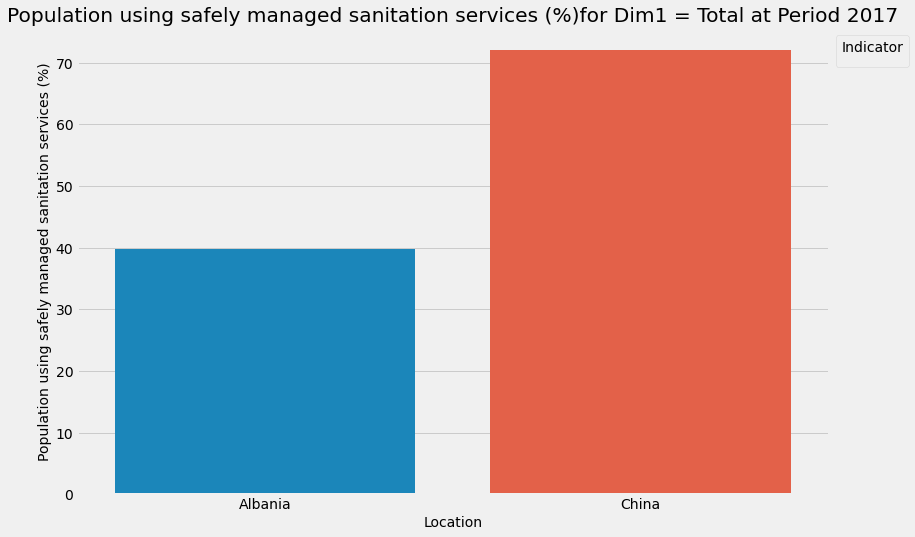

In [30]:
plot_first_tooltip_by_location(health_data, 2017, None, ["China","Albania"])

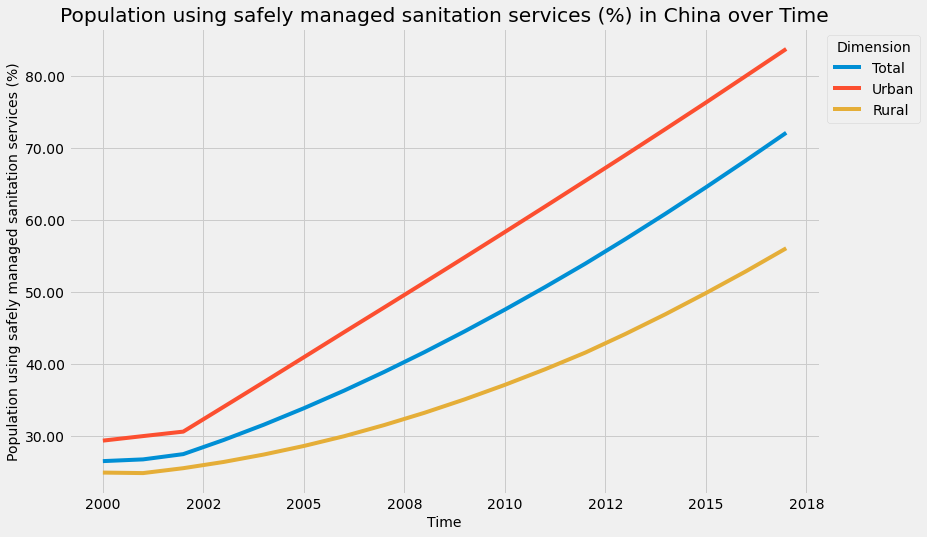

In [31]:
lineplot(health_data, "China")

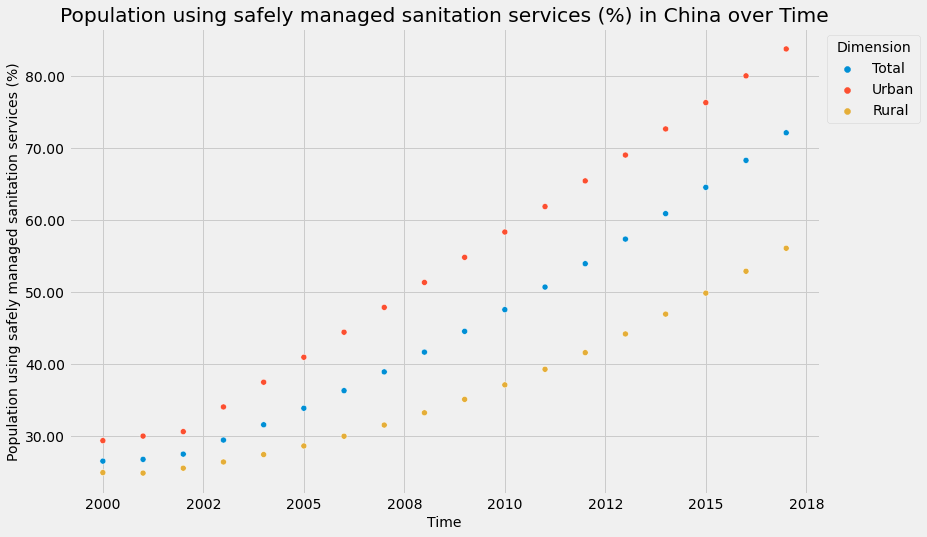

In [32]:
scatterplot(health_data, "China")

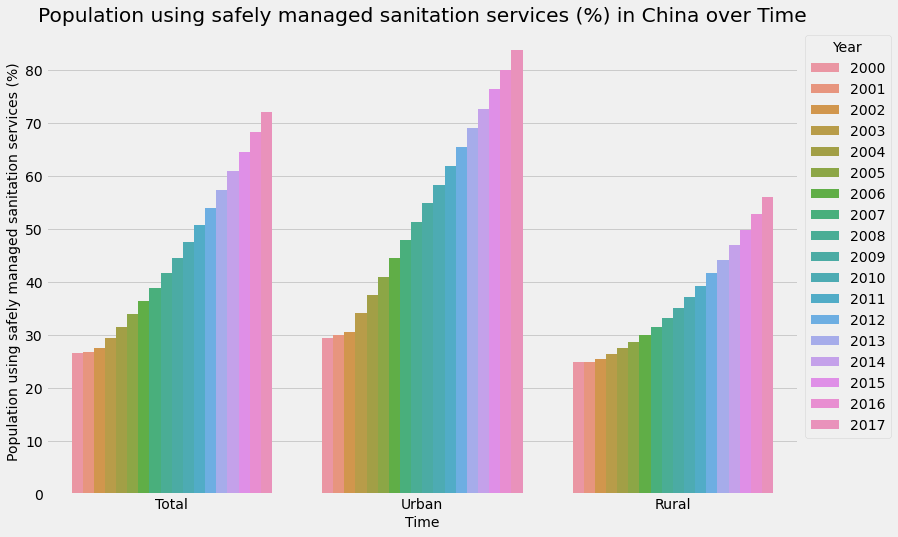

In [33]:
barplot(health_data, "China")

In [34]:
map_sanitation = create_geomap(health_data,year=2020, dim1='Total')
map_sanitation

No data available for the year 2020 and dimension Total


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Reflection:


We implemented the geomap while it failed to show up in the jupyter notebook. So our next step would be to figure out how to display map as a function in a function way as a python package.
We want to explore other potential graphs that can help the user consume raw data and provide additional insights. For instance, a user can have two csv files read in and compare how one factor affects the other by visualizations. 
Another important thing to address is we want to first validate the form of the csv file the package reads in. For instance, it at least has to have three columns that are respectively location, time periods and the corresponding value. So we want to implement an error handling function to filter out those csv that don't meet the criteria. 
Lastly, the current graphs don't have the best aesthetics and we want to refine them.